In [ ]:
   # TUMOR TYPES
    #"0" : nolabel,
    # "1" : epithelial ,
    # "2"  : inflammatory,
    # "3" : spindle,
    # "4" : miscellenous,
    # "5" : epithelial

#

In [2]:
import torch.cuda

print(torch.cuda.is_available())

False
False


In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
import json
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from nurisc import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from nurisc.matching import matching, matching_dataset
from nurisc.models import Config2D, nurisc2D, nuriscData2D
from nurisc.utils import mask_to_categorical
from nurisc.plot import render_label


np.random.seed(0)
lbl_cmap = random_label_cmap()
lbl_cmap_classes = matplotlib.cm.tab10

def plot_img_label(img, lbl, cls_dict, n_classes=6, img_title="image", lbl_title="label", cls_title="classes", **kwargs):
    c = mask_to_categorical(lbl, n_classes=n_classes, classes=cls_dict)
    res = np.zeros(lbl.shape, np.uint16)
    for i in range(1,c.shape[-1]):
        m = c[...,i]>0
        res[m] = i
    class_img = lbl_cmap_classes(res)
    # class_img[...,:3][res==0] = 0
    # class_img[...,-1][res==0] = 1

    fig, (ai,al,ac) = plt.subplots(1,3, figsize=(17,7), gridspec_kw=dict(width_ratios=(1.,1,1)))
    im = ai.imshow(img, cmap='gray')
    #fig.colorbar(im, ax = ai)
    ai.set_title(img_title)
    al.imshow(render_label(lbl, .8*normalize(img, clip=True), normalize_img=False, alpha_boundary=.8,cmap=lbl_cmap))
    al.set_title(lbl_title)
    ac.imshow(class_img)
    ac.imshow(render_label(res, .8*normalize(img, clip=True), normalize_img=False, alpha_boundary=.8, cmap=lbl_cmap_classes))
    ac.set_title(cls_title)
    plt.tight_layout()
    for a in ai,al,ac:
        a.axis("off")
    return ai,al,ac

C:\Users\es255022\AppData\Local\Temp\ipykernel_13612\956331175.py:5: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams["image.interpolation"] = None


In [2]:
# set the number of object classes
n_classes = 7

In [3]:
import numpy as np
import glob

np.random.seed(42)

Data = sorted(glob.glob('C:/Users/es255022/hover_net/dataset/training_data/consep1/consep/train/*.npy'))
print(Data)
Data1  = list(map(np.load,Data))

X=[x[...,(0,1,2)] for x in Data1]
Y=[y[...,3]for y in Data1]
Y1=[y[...,3]for y in Data1]
cls_dict=[cls[...,4]for cls in Data1]
cls1=[cls[...,4]for cls in Data1]

Y3 = [[0 for x in range(291600)] for y in range(1322)]
for i in range(1322):
    Y3[i]=Y[i].flatten()
CL3 = [[0 for x in range(291600)] for y in range(1322)]
for i in range(1322):
    CL3[i]=cls_dict[i].flatten()
CLS3 = [[0 for x in range(291600)] for y in range(1322)]

CLS3[0]=cls_dict[0].flatten()
my_cls=[]
for i in range(1322):
    my_cls.append(dict(zip(Y3[i], CL3[i])))
cls=(*my_cls,)
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]


['C:/Users/es255022/hover_net/dataset/training_data/consep1/consep/train\\train_10_000.npy', 'C:/Users/es255022/hover_net/dataset/training_data/consep1/consep/train\\train_10_001.npy', 'C:/Users/es255022/hover_net/dataset/training_data/consep1/consep/train\\train_10_002.npy', 'C:/Users/es255022/hover_net/dataset/training_data/consep1/consep/train\\train_10_003.npy', 'C:/Users/es255022/hover_net/dataset/training_data/consep1/consep/train\\train_10_004.npy', 'C:/Users/es255022/hover_net/dataset/training_data/consep1/consep/train\\train_10_005.npy', 'C:/Users/es255022/hover_net/dataset/training_data/consep1/consep/train\\train_10_006.npy', 'C:/Users/es255022/hover_net/dataset/training_data/consep1/consep/train\\train_10_007.npy', 'C:/Users/es255022/hover_net/dataset/training_data/consep1/consep/train\\train_10_008.npy', 'C:/Users/es255022/hover_net/dataset/training_data/consep1/consep/train\\train_10_009.npy', 'C:/Users/es255022/hover_net/dataset/training_data/consep1/consep/train\\train_

In [4]:
cls_count=[cls[...,4]for cls in Data1]

In [6]:
class1=np.zeros(5)
print(len(cls_count))
print(np.unique(cls_count))


1323
[0 1 2 3 4]


In [6]:
print(class1[3])

0.0


Generate a synthetic training set of 100 random images, label masks, and class dictionaries.

Normalize images and fill small label holes.

In [7]:
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
# print(len(X))

axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y1)]

Normalizing image channels independently.


100%|██████████| 1323/1323 [00:34<00:00, 38.91it/s]


Split into train and validation datasets.

In [8]:
tuple1=(*my_cls,)

In [9]:


assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
print(n_val)
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
print(len(ind[:-n_val]))
print(len(ind[-n_val:]))
print(len(my_cls))
print(len(ind_train))
X_val, Y_val, C_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val] , [my_cls[i] for i in ind_val]
for i in range(len(ind_train)):
    if(ind_train[i]==1322):
        print('yes')
        print(i)
        ind_train[i]=1247
        break;
X_trn, Y_trn, C_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train],  [tuple1[i] for i in ind_train]


198
1125
198
1322
1125
yes
908


Training data consists of pairs of input image and label instances.

# Configuration

A `nurisc2D` model is specified via a `Config2D` object.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 3 3 3 3 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 0 0 0 0 0 0 0 0 0 0 

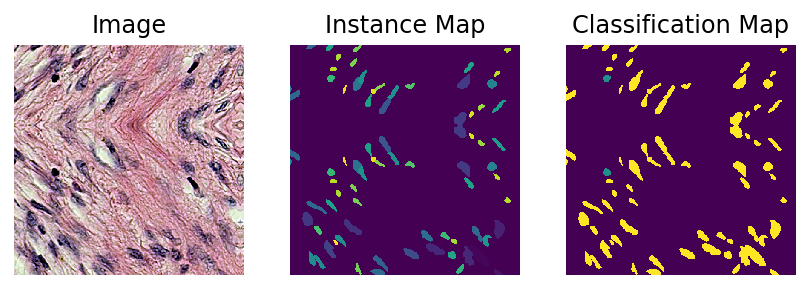

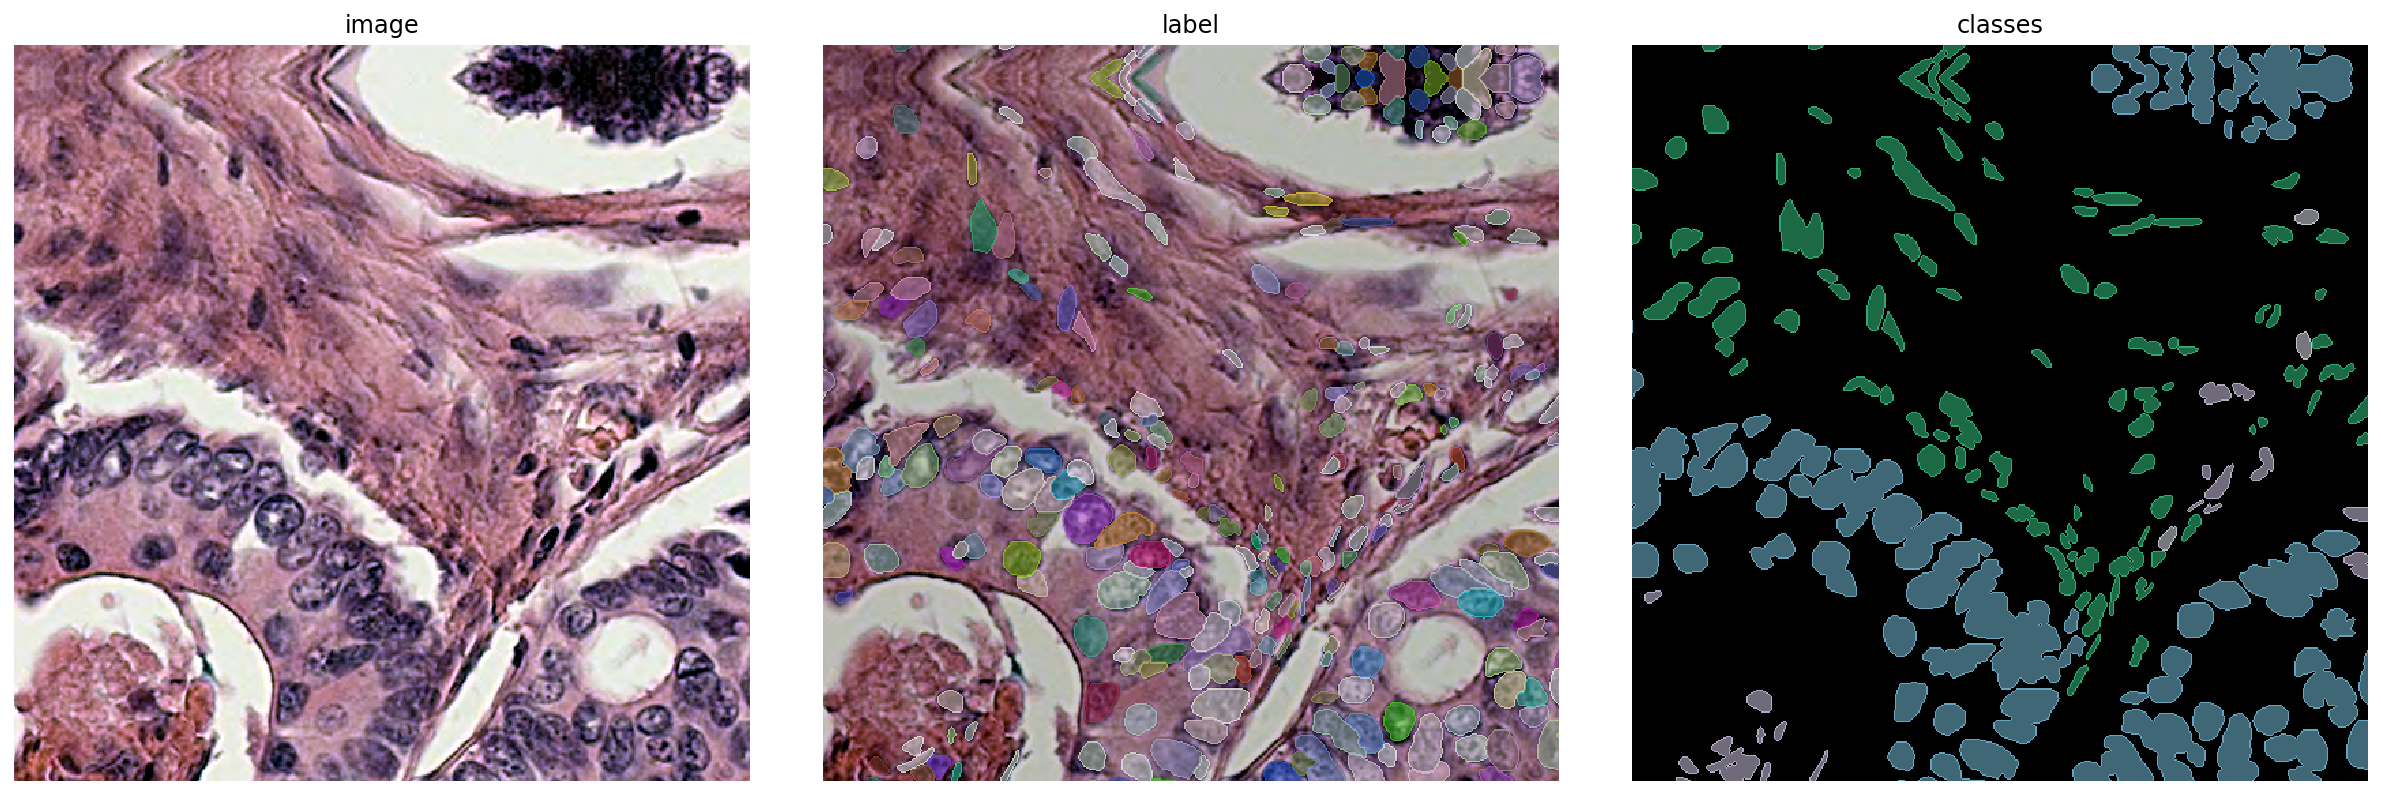

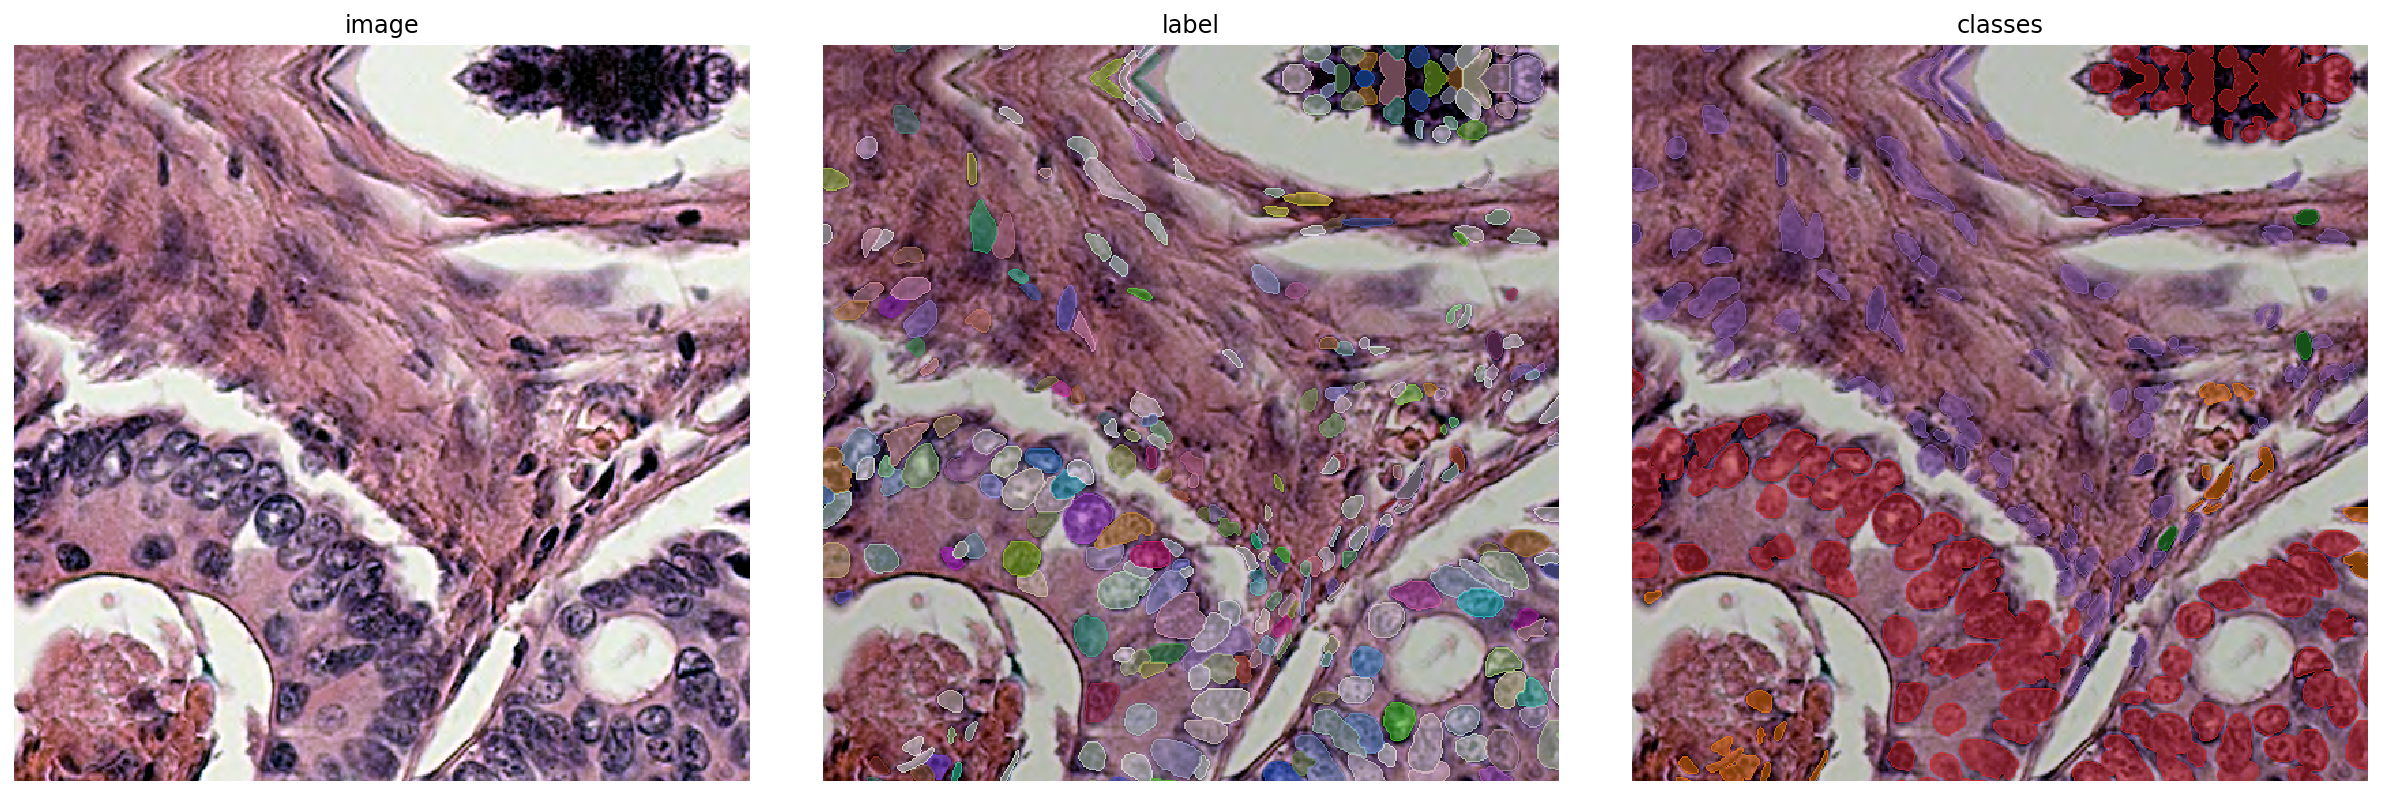

In [10]:
# ax = plot_img_label(X[100],Y[100],tuple1[100], n_classes=4)
viz_dict = {"Image": X[200], "Instance Map": Y[200], "Classification Map": cls1[200]}
fig = plt.figure(figsize=(7,10))
count = 1
for img_name, img in viz_dict.items():
  ax = plt.subplot(1,3, count)
  plt.imshow(img)
  plt.title(img_name)
  plt.axis("off")
  count += 1
# for a in ax: a.axis("off");

def plot_img_update(img, lbl, cls_dict, n_classes=4, img_title="image", lbl_title="label", cls_title="classes", **kwargs):
    # c = mask_to_categorical(lbl, n_classes=n_classes, classes=cls_dict)
    # res = np.zeros(lbl.shape, np.uint16)
    # for i in range(1,cls_dict.shape[-1]):
    #     m = cls_dict[...,i]>0
    #     res[m] = i
    # cls_dict = lbl_cmap_classes(res)
    # # class_img[...,:3][res==0] = 0
    # # class_img[...,-1][res==0] = 1

    fig, (ai,al,ac) = plt.subplots(1,3, figsize=(17,7), gridspec_kw=dict(width_ratios=(1.,1,1)))
    im = ai.imshow(img, cmap='gray')
    #fig.colorbar(im, ax = ai)
    ai.set_title(img_title)
    al.imshow(render_label(lbl, .8*normalize(img, clip=True), normalize_img=False, alpha_boundary=.8,cmap=lbl_cmap))
    al.set_title(lbl_title)
    ac.imshow(cls_dict)
    ac.imshow(render_label(cls_dict, normalize_img=False, alpha_boundary=.8, cmap=lbl_cmap))
    ac.set_title(cls_title)
    plt.tight_layout()
    for a in ai,al,ac:
        a.axis("off")
    return ai,al,ac
ax = plot_img_update(X[450],Y[450],cls1[450], n_classes=4)
ax = plot_img_label(X[450],Y[450],tuple1[450], n_classes=4)
# print(cls[450].flatten())
for i in range(len(cls1[450])):
     print(cls1[450][i])


In [11]:
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

In [12]:
# 32 is a good default choice
n_rays = 32
n_classes=4
# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

# conf = Config2D (
#     n_rays       = n_rays,
#     grid         = grid,
#     use_gpu      = True,
#     n_channel_in = n_channel,
#     n_classes    = n_classes,# set the number of object classes
#     train_dist_loss           = 'mae',
#     backbone='unet',
#     # unet_n_depth=4,
#     # train_focal_gamma=1.33,
#     train_class_weights=(0,1,0.7,0.6,0.7),
#
#
# )
# print(conf)
# vars(conf)

If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3


In [13]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    limit_gpu_memory(None, allow_growth=True)


In [14]:
model = nurisc2D(config=None, name='nurisc_multiclass', basedir='models')

FileNotFoundError: config file doesn't exist: C:\Users\es255022\PycharmProjects\pCDNet\oregon\examples\other2D\models\stardist_multiclass\config.json

In [ ]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]]


In [ ]:
def random_fliprot(img, mask):
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim)))
    mask = mask.transpose(perm)
    for ax in axes:
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

In [ ]:

tuple1 = (*my_cls,)

In [ ]:
print(type(tuple1))

In [ ]:
img_aug,label_aug,cls=[X[i] for i in ind_train], [Y[i] for i in ind_train],  [tuple1[i] for i in ind_train]

In [ ]:
# plot some augmented examples

img, lbl, cls = X[0], Y[0], tuple1[0]
plot_img_label(img,lbl,cls, n_classes=4)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug,lbl_aug,cls, img_title="image augmented", lbl_title="label augmented", n_classes=n_classes)
# None;

In [ ]:
# img, lbl, cls = X[0], Y[0], tuple1[0]
# # plot_img_label(img,lbl,cls, n_classes=4)
# for i in range(len(X)):
#     img_aug[i], lbl_aug[i] = augmenter(X[i],Y[i])
#     # plot_img_label(img_aug,lbl_aug,cls, img_title="image augmented", lbl_title="label augmented", n_classes=n_classes)
# None;

In [ ]:
# X_new,Y_new_C_new=augmenter()

In [ ]:
# import keras
# keras.utils.plot_model(model, "my_first_model.png")
model.train(X_trn,Y_trn, classes=C_trn, validation_data=(X_val,Y_val,C_val),augmenter=augmenter,
           epochs=100, steps_per_epoch=64)

# print(len(X_val))
# print(len(Y_val))
# print(len(C_val))# 200 epochs seem to be enough for synthetic demo dataset

In [ ]:
from csbdeep.models import base_model
model.load_weights('C:/Users/es255022/PycharmProjects/pCDNet/oregon/examples/other2D/models/nurisc_multiclass/pannuke_100epoch/weights_best.h5')

In [ ]:
# from focal_loss import _categorical_focal_loss
# model.compile(loss=[_categorical_focal_loss(alpha=[[.25, .25, .25]], gamma=2)], metrics=["accuracy"], optimizer=adam)

In [ ]:
# model.optimize_thresholds(X_val, Y_val)

In [ ]:
i = 8
label, res = model.predict_instances(X_val[i], n_tiles=model._guess_n_tiles(X_val[i]))
print(label)
print(res)

In [ ]:
# the class object ids are stored in the 'results' dict and correspond to the label ids in increasing order 

def class_from_res(res):
    cls_dict = dict((i+1,c) for i,c in enumerate(res['class_id']))
    return cls_dict

print(class_from_res(res))

In [ ]:
n_classes=5
plot_img_label(X_val[i], Y_val[i], C_val[i],            lbl_title="GT")
plot_img_label(X_val[i], label,    class_from_res(res), lbl_title="Pred");

In [ ]:
Y_val_pred, res_val_pred = tuple(zip(*[model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)
              for x in tqdm(X_val[:])]))

In [ ]:
i = 100
plot_img_label(X_val[i],Y_val[i],      C_val[i],                        lbl_title="label GT")
plot_img_label(X_val[i],Y_val_pred[i], class_from_res(res_val_pred[i]), lbl_title="label Pred");

In [ ]:

# plot an example
np.random.seed(42)
# x,y,cls_dict = generate_sample()
#CONSEP
test_data = sorted(glob.glob('C:/Users/es255022/hover_net/dataset/training_data/consep1/consep/valid/540x540_164x164/*.npy'))
# print(Data)
test = list(map(np.load,test_data))
# print(Data1[0].shape)
X_test=[x[...,(0,1,2)] for x in test]
Y_test=[y[...,3]for y in test]
Y1=[y[...,3]for y in test]
cls_test=[cls[...,4]for cls in test]
for i in range(1):
                     print(cls_test[i])
                     print(np.shape(cls_test[i]))
print(len(X_test))
print(len(Y_test))
print(len(Y1))
# print(cls_dict.type)
# cls_dict1=cls_dict.flatten()
# print(len(cls_dict1))
# X=[ y[...,(0,1,2) for y in Data1]

#---------------COMMENT/UNCOMMENT-------------------------------------------------------------
#---shape 540x540=291600
Y3 = [[0 for x in range(291600)] for y in range(686)]
for i in range(686):
    Y3[i]=Y1[i].flatten()
CL3 = [[0 for x in range(291600)] for y in range(686)]
for i in range(686):
    CL3[i]=cls_test[i].flatten()
CLS3 = [[0 for x in range(291600)] for y in range(686)]

CLS3[0]=cls_test[0].flatten()
test_cls=[]
for i in range(686):
    test_cls.append(dict(zip(Y3[i], CL3[i])))
Test_clss=(*test_cls,)
# n_channel = 1 if X_test[0].ndim == 2 else X[0].shape[-1]



test_img = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X_test)]

# Y_val_pred, res_val_pred = tuple(zip(*[model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)
#               for x in tqdm(X_val[:])]))



Choose several IoU thresholds $\tau$ that might be of interest and for each compute matching statistics for the validation data.

In [ ]:

Y_test_pred, res_test_pred = tuple(zip(*[model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)  for x in tqdm(test_img[:])]))

In [ ]:
Y_test_pred, res_test_pred = tuple(zip(*[model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)  for x in tqdm(test_img[:])]))

In [ ]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

Example: Print all available matching statistics for $\tau=0.5$

In [ ]:
stats[taus.index(0.5)]

In [ ]:
taus_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats_test = [matching_dataset(Y_test, Y_test_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

In [ ]:
stats_test[taus_test.index(0.5)]

Plot the matching statistics and the number of true/false positives/negatives as a function of the IoU threshold $\tau$. 

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('Precision', 'Recall', 'Accuracy', 'F1', 'mean_true_score', 'mean_matched_score', 'Panoptic_Quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('FP', 'TP', 'FN'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('Precision', 'Recall', 'Accuracy', 'F1', 'mean_true_score', 'mean_matched_score', 'Panoptic_Quality'):
    ax1.plot(taus_test, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('FP', 'TP', 'FN'):
    ax2.plot(taus_test, [s._asdict()[m] for s in stats_test], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
# type_true = type_of_target(y_true, input_name="y_true")
# type_pred = type_of_target(y_pred, input_name="y_pred")
# print(type_true)
# print(type_pred)
y_type="multiclass"
confusion_matrix = metrics.confusion_matrix(Y_val, Y_val_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()